In [ ]:
import numpy as np
import torch
import sys
import copy
import random
import numpy as np
from collections import defaultdict
from multiprocessing import Process, Queue
import json
import os
import time
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PointWiseFeedForward(torch.nn.Module):
    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = torch.nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs

# pls use the following self-made multihead attention layer
# in case your pytorch version is below 1.16 or for other reasons
# https://github.com/pmixer/TiSASRec.pytorch/blob/master/model.py

class SASRec(torch.nn.Module):
    def __init__(self, user_num, item_num, args):
        super(SASRec, self).__init__()

        self.user_num = user_num
        self.item_num = item_num
        self.dev = args.device

        # TODO: loss += args.l2_emb for regularizing embedding vectors during training
        # https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        self.item_emb = torch.nn.Embedding(self.item_num+1, args.hidden_units, padding_idx=0)
        self.pos_emb = torch.nn.Embedding(args.maxlen+1, args.hidden_units, padding_idx=0)
        self.emb_dropout = torch.nn.Dropout(p=args.dropout_rate)

        self.attention_layernorms = torch.nn.ModuleList() # to be Q for self-attention
        self.attention_layers = torch.nn.ModuleList()
        self.forward_layernorms = torch.nn.ModuleList()
        self.forward_layers = torch.nn.ModuleList()

        self.last_layernorm = torch.nn.LayerNorm(args.hidden_units, eps=1e-8)

        for _ in range(args.num_blocks):
            new_attn_layernorm = torch.nn.LayerNorm(args.hidden_units, eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)

            new_attn_layer =  torch.nn.MultiheadAttention(args.hidden_units,
                                                            args.num_heads,
                                                            args.dropout_rate)
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = torch.nn.LayerNorm(args.hidden_units, eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(args.hidden_units, args.dropout_rate)
            self.forward_layers.append(new_fwd_layer)

            # self.pos_sigmoid = torch.nn.Sigmoid()
            # self.neg_sigmoid = torch.nn.Sigmoid()

    def log2feats(self, log_seqs): # TODO: fp64 and int64 as default in python, trim?
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.dev))
        seqs *= self.item_emb.embedding_dim ** 0.5
        poss = np.tile(np.arange(1, log_seqs.shape[1] + 1), [log_seqs.shape[0], 1])
        # TODO: directly do tensor = torch.arange(1, xxx, device='cuda') to save extra overheads
        poss *= (log_seqs != 0)
        seqs += self.pos_emb(torch.LongTensor(poss).to(self.dev))
        seqs = self.emb_dropout(seqs)

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.ones((tl, tl), dtype=torch.bool, device=self.dev))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](Q, seqs, seqs,
                                            attn_mask=attention_mask)
                                            # need_weights=False) this arg do not work?
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, user_ids, log_seqs, pos_seqs, neg_seqs): # for training
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.dev))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.dev))

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        # pos_pred = self.pos_sigmoid(pos_logits)
        # neg_pred = self.neg_sigmoid(neg_logits)

        return pos_logits, neg_logits # pos_pred, neg_pred

    def predict(self, user_ids, log_seqs, item_indices): # for inference
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        final_feat = log_feats[:, -1, :] # only use last QKV classifier, a waste

        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.dev)) # (U, I, C)

        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)

        # preds = self.pos_sigmoid(logits) # rank same item list for different users

        return logits # preds # (U, I)

In [ ]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data_dir = 'drive/My Drive/puc/rec/project/data'
data_file = 'playlistid_itemid_1000p_train.txt'

def build_index(n_users=999, n_items=34443):

    ui_mat = np.loadtxt(f'{data_dir}/{data_file}', dtype=np.int32)

    n_users = ui_mat[:, 0].max()
    n_items = ui_mat[:, 1].max()

    u2i_index = [[] for _ in range(n_users + 1)]
    i2u_index = [[] for _ in range(n_items + 1)]

    for ui_pair in ui_mat:
        u2i_index[ui_pair[0]].append(ui_pair[1])
        i2u_index[ui_pair[1]].append(ui_pair[0])

    return u2i_index, i2u_index

# sampler for batch generation
def random_neq(l, r, s):
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t


def sample_function(user_train, usernum, itemnum, batch_size, maxlen, result_queue, SEED):
    def sample(uid):

        # uid = np.random.randint(1, usernum + 1)
        user_train_keys = list(user_train.keys())
        while (uid not in user_train) or (len(user_train[uid]) <= 1):
          uid = np.random.randint(1, usernum + 1)

        seq = np.zeros([maxlen], dtype=np.int32)
        pos = np.zeros([maxlen], dtype=np.int32)
        neg = np.zeros([maxlen], dtype=np.int32)
        nxt = user_train[uid][-1]
        idx = maxlen - 1

        ts = set(user_train[uid])
        for i in reversed(user_train[uid][:-1]):
            seq[idx] = i
            pos[idx] = nxt
            if nxt != 0: neg[idx] = random_neq(1, itemnum + 1, ts)
            nxt = i
            idx -= 1
            if idx == -1: break

        return (uid, seq, pos, neg)

    np.random.seed(SEED)

    # user_train_uids = np.array(list(user_train.keys()))

    uids = np.arange(1, usernum+1, dtype=np.int32)
    # uids = uids[np.isin(uids, user_train_uids)]
    counter = 0
    while True:
        if counter % usernum == 0:
            np.random.shuffle(uids)
        one_batch = []
        for i in range(batch_size):
            one_batch.append(sample(uids[counter % usernum]))
            counter += 1
        result_queue.put(zip(*one_batch))


# train/val/test data generation
def data_partition():
    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    user_train = {}
    user_valid = {}
    user_test = {}
    # assume user/item index starting from 1
    f = open(f'{data_dir}/{data_file}', 'r')
    for line in f:
        u, i = line.rstrip().split(' ')
        u = int(u)
        i = int(i)
        usernum = max(u, usernum)
        itemnum = max(i, itemnum)
        User[u].append(i)

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 3:
            user_train[user] = User[user]
            user_valid[user] = []
            user_test[user] = []
        else:
            user_train[user] = User[user][:-2]
            user_valid[user] = []
            user_valid[user].append(User[user][-2])
            user_test[user] = []
            user_test[user].append(User[user][-1])
    return [user_train, user_valid]

# TODO: merge evaluate functions for test and val set
# evaluate on test set
def evaluate(model, dataset, args):
    [train, valid, test, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:

        if len(train[u]) < 1 or len(test[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        rated = set(train[u])
        rated.add(0)
        item_idx = [test[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0] # - for 1st argsort DESC

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user


# evaluate on val set
def evaluate_valid(model, dataset, args):
    [train, valid, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    valid_user = 0.0
    HT = 0.0
    users= train.keys()
    # if usernum>10000:
    #     users = random.sample(range(1, usernum + 1), 10000)
    # else:
    #     users = range(1, usernum + 1)
    for u in users:
        if len(train[u]) < 1 or len(valid[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break

        rated = set(train[u])
        rated.add(0)
        item_idx = [valid[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0]

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user

In [ ]:
def str2bool(s):
    if s not in {'false', 'true'}:
        raise ValueError('Not a valid boolean string')
    return s == 'true'

# parser.add_argument('--dataset', required=True)
# parser.add_argument('--train_dir', required=True)
# parser.add_argument('--batch_size', default=128, type=int)
# parser.add_argument('--lr', default=0.001, type=float)
# parser.add_argument('--maxlen', default=200, type=int)
# parser.add_argument('--hidden_units', default=50, type=int)
# parser.add_argument('--num_blocks', default=2, type=int)
# parser.add_argument('--num_epochs', default=1000, type=int)
# parser.add_argument('--num_heads', default=1, type=int)
# parser.add_argument('--dropout_rate', default=0.2, type=float)
# parser.add_argument('--l2_emb', default=0.0, type=float)
# parser.add_argument('--device', default='cuda', type=str)
# parser.add_argument('--inference_only', default=False, type=str2bool)
# parser.add_argument('--state_dict_path', default=None, type=str)


# if not os.path.isdir(args.dataset + '_' + args.train_dir):
#     os.makedirs(args.dataset + '_' + args.train_dir)
# with open(os.path.join(args.dataset + '_' + args.train_dir, 'args.txt'), 'w') as f:
#     f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))
# f.close()

class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = Args(
    batch_size=256,
    hidden_units=1024,
    maxlen=200,
    num_blocks=2,
    num_heads=1,
    device='cuda',
    state_dict_path=None,
    inference_only=False,
    l2_emb=0.0,
    dropout_rate=0.2,
    num_epochs=100,
    lr=0.001,
    train_dir='drive/My Drive/puc/rec/project/models',
    dataset='playlistid_itemid_1000p_train'
)


# args.batch_size = 128
# args.hidden_units = 50
# args.maxlen = 200
# args.num_blocks = 2
# args.num_heads = 1
# args.device = 'cuda'

# args.state_dict_path = None
# args.inference_only = False

# args.l2_emb = 0.0
# args.dropout_rate = 0.2
# args.num_epochs = 1000


u2i_index, i2u_index = build_index()

# global dataset
dataset = data_partition()

usernum = 999
itemnum = 34443

[user_train, user_valid] = dataset
dataset.append(usernum)
dataset.append(itemnum)
# num_batch = len(user_train) // args.batch_size # tail? + ((len(user_train) % args.batch_size) != 0)
num_batch = (len(user_train) - 1) // args.batch_size + 1
cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))

# f = open(os.path.join(args.dataset + '_' + args.train_dir, 'log.txt'), 'w')
# f.write('epoch (val_ndcg, val_hr) (test_ndcg, test_hr)\n')

sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen, n_workers=3)

average sequence length: 61.61


In [ ]:
model = SASRec(usernum, itemnum, args).to(args.device) # no ReLU activation in original SASRec implementation?

for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

model.pos_emb.weight.data[0, :] = 0
model.item_emb.weight.data[0, :] = 0

# this fails embedding init 'Embedding' object has no attribute 'dim'
# model.apply(torch.nn.init.xavier_uniform_)

model.train() # enable model training

epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
        tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()


if args.inference_only:
    model.eval()
    t_test = evaluate(model, dataset, args)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

# ce_criterion = torch.nn.CrossEntropyLoss()
# https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

best_val_ndcg, best_val_hr = 0.0, 0.0
best_test_ndcg, best_test_hr = 0.0, 0.0
T = 0.0
t0 = time.time()


train_losses = []
ndcgs_valid = []
ndcgs_test = []
hr_valid = []
hr_test = []


for epoch in range(epoch_start_idx, args.num_epochs + 1):
    if args.inference_only: break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs
        train_losses.append(loss.item())

    if epoch % 20 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        # print('Evaluating', end='')
        # t_test = evaluate(model, dataset, args)
        t_valid = evaluate_valid(model, dataset, args)
        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1]))
        ndcgs_valid.append(t_valid[0])
        hr_valid.append(t_valid[1])


        if t_valid[0] > best_val_ndcg or t_valid[1] > best_val_hr:
            best_val_ndcg = max(t_valid[0], best_val_ndcg)
            best_val_hr = max(t_valid[1], best_val_hr)
            # folder = args.dataset + '_' + args.train_dir
            # fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
            # fname = fname.format(epoch, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
            # torch.save(model.state_dict(), os.path.join(folder, fname))

        # f.write(str(epoch) + ' ' + str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()

    # if epoch == args.num_epochs:
    #     folder = args.dataset + '_' + args.train_dir
    #     fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
    #     fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
    #     torch.save(model.state_dict(), os.path.join(folder, fname))

# f.close()
sampler.close()
print("Done")

loss in epoch 1 iteration 0: 1.4010261297225952
loss in epoch 1 iteration 1: 1.3450183868408203
loss in epoch 1 iteration 2: 1.2846227884292603
loss in epoch 1 iteration 3: 1.2048124074935913
loss in epoch 2 iteration 0: 1.1600264310836792
loss in epoch 2 iteration 1: 1.1409796476364136
loss in epoch 2 iteration 2: 1.0514711141586304
loss in epoch 2 iteration 3: 1.0122687816619873
loss in epoch 3 iteration 0: 0.9672465324401855
loss in epoch 3 iteration 1: 0.9296584129333496
loss in epoch 3 iteration 2: 0.884010910987854
loss in epoch 3 iteration 3: 0.850741982460022
loss in epoch 4 iteration 0: 0.7496381998062134
loss in epoch 4 iteration 1: 0.7228531241416931
loss in epoch 4 iteration 2: 0.6824131011962891
loss in epoch 4 iteration 3: 0.6983879208564758
loss in epoch 5 iteration 0: 0.6494124531745911
loss in epoch 5 iteration 1: 0.6382715702056885
loss in epoch 5 iteration 2: 0.6181628704071045
loss in epoch 5 iteration 3: 0.610024631023407
loss in epoch 6 iteration 0: 0.586790382862

In [ ]:
import matplotlib.pyplot as plt

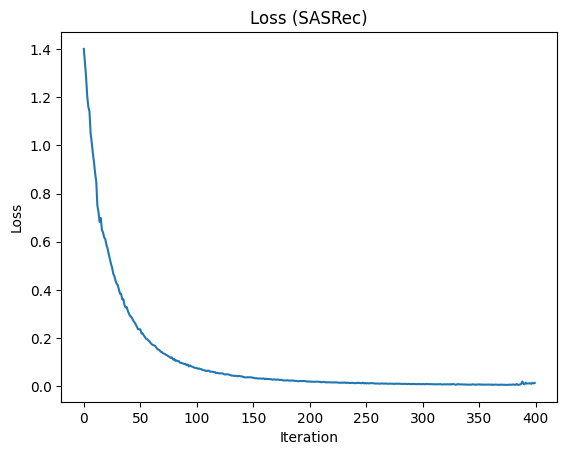

In [ ]:
plt.plot(train_losses)
plt.title('Loss (SASRec)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
def read_interactions(file):
  ui_mat = np.loadtxt(f'{file}', dtype=np.int32)
  return ui_mat

In [ ]:
test_challenge_file_path = '/content/drive/My Drive/puc/rec/project/data/test_challenge_200p.txt'
test_challenge_dataset = read_interactions(test_challenge_file_path)

In [ ]:
import math

In [ ]:
def dcg(recommended_items, rel_items_labels):
  dcg_value = 0
  for idx, rel in enumerate(rel_items_labels):
    i = idx + 1
    dcg_value += ((2**rel-1)/math.log2(i + 1))
  return dcg_value

def ndcg(recommended_items, relevant_items):
  rel_items_labels = np.isin(recommended_items, relevant_items)
  count_rel_items = np.sum(rel_items_labels)
  ideal_rel_items_labels = np.concatenate([np.ones(count_rel_items, dtype=int), np.zeros(len(rel_items_labels) - count_rel_items, dtype=int)])
  dcg_value = dcg(recommended_items, rel_items_labels)
  ideal_dcg_value = dcg(recommended_items, ideal_rel_items_labels)
  ndcg_value = 0
  if dcg_value != 0:
    ndcg_value = dcg_value / ideal_dcg_value
  return ndcg_value

In [ ]:
from itertools import combinations

In [ ]:
idx2uri = read_json_file(f'{data_dir}/idx2uri.json')
genres = read_json_file(f'{data_dir}/uri2genres.json')

In [ ]:
def id2genre(idx):
  uri = idx2uri[str(idx)]
  if uri in genres:
    return genres[uri]
  else:
    return 'None'

In [ ]:
def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items)
    return recall

def precision_at_k(relevant_items, recommended_items, k):
    """
    Calcula la precisión en los primeros k elementos recomendados.

    Parameters:
        relevant_items (list): Lista de elementos relevantes.
        recommended_items (list): Lista ordenada de elementos recomendados.
        k (int): Número de elementos recomendados a considerar.

    Returns:
        float: Precision@k.
    """
    relevant_items = set(relevant_items)
    recommended_items = recommended_items[:k]
    relevant_recommended = [item for item in recommended_items if item in relevant_items]
    precision = len(relevant_recommended) / k
    return precision

In [ ]:
def dcg(recommended_items, rel_items_labels):
  dcg_value = 0
  for idx, rel in enumerate(rel_items_labels):
    i = idx + 1
    dcg_value += ((2**rel-1)/math.log2(i + 1))
  return dcg_value

def ndcg_eq(recommended_items, relevant_items, k=10):
  recommended_items = recommended_items[:k]
  rel_items_labels = np.isin(recommended_items, relevant_items)
  count_rel_items = np.sum(rel_items_labels)
  ideal_rel_items_labels = np.concatenate([np.ones(count_rel_items, dtype=int), np.zeros(len(rel_items_labels) - count_rel_items, dtype=int)])
  dcg_value = dcg(recommended_items, rel_items_labels)
  ideal_dcg_value = dcg(recommended_items, ideal_rel_items_labels)
  ndcg_value = 0
  if dcg_value != 0:
    ndcg_value = dcg_value / ideal_dcg_value
  return ndcg_value

In [ ]:
from itertools import combinations

In [ ]:
def diversity_at_n(recommendations, n):
    genres = [id2genre(id) for id in recommendations]
    genres = genres[:n]
    num_elements = len(genres)

    if num_elements <= 1:
        return 0

    def distance(genre1, genre2):
        return 1 if genre1 != genre2 else 0

    pairwise_distances = [
        distance(g1, g2) for g1, g2 in combinations(genres, 2)
    ]
    return sum(pairwise_distances) / len(pairwise_distances)

In [ ]:
def get_metrics(recommendations, relevant_items, k=10):
    #ndcg = calculate_ndcg(recommendations, relevant_items, k)
    ndcg = ndcg_eq(recommendations, relevant_items, k)
    recall = recall_at_k(relevant_items, recommendations, k)
    precision = precision_at_k(relevant_items, recommendations, k)
    diversity = diversity_at_n(recommendations, k)
    return ndcg, recall, precision, diversity

In [ ]:
def eval(test_interactions_dataset, train, k=25, n_inputs = 5, n_playlists = 200):
  ndcgs = []
  recalls = []
  precisions = []
  diversities = []
  tracks_per_playlist = int(len(test_interactions_dataset) / n_playlists)
  interactions_idx = 0
  while interactions_idx < len(test_interactions_dataset):
    input_items = []
    playlist_id = test_interactions_dataset[interactions_idx][0]
    while len(input_items) < n_inputs:
      input_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1
    ground_trouth_items = []
    while len(ground_trouth_items) < tracks_per_playlist - n_inputs:
      ground_trouth_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1

    seq = np.zeros([args.maxlen], dtype=np.int32)
    idx = args.maxlen - 1
    for i in reversed(input_items):
        seq[idx] = i
        idx -= 1
        if idx == -1: break

    input_seq_set = set(input_items)
    candidate_items = []
    for item in list(range(1,itemnum + 1)):
      if item not in input_seq_set:
        candidate_items.append(item)

    predictions = -model.predict(*[np.array(l) for l in [[playlist_id], [seq], candidate_items]])
    predictions = predictions[0]
    predicted_tracks = []
    for candidate_item_idx in predictions.argsort():
      predicted_tracks.append(candidate_items[candidate_item_idx])
    ndcg_val, recall_val, precision_val, diversity_val = get_metrics(predicted_tracks, ground_trouth_items, k=k)
    ndcgs.append(ndcg_val)
    recalls.append(recall_val)
    precisions.append(precision_val)
    diversities.append(diversity_val)
  return np.mean(ndcgs), np.mean(recalls), np.mean(precisions), np.mean(diversities)

In [ ]:
ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 1)
ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 1)
ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 1)

ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 5)
ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 5)
ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 5)

print('Input: 1 track')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1))
print('@25 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1))

print('Input: 5 tracks')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5))


Input: 1 track
@10 NDCG 0.1501594374073178 Reccall 0.014193349753694582 Precision 0.040999999999999995 Diversity 0.8388888888888889
@20 NDCG 0.16440004375965472 Reccall 0.023541096515234443 Precision 0.034 Diversity 0.8643947368421052
@25 NDCG 0.16789114720376305 Reccall 0.02734035759897829 Precision 0.0316 Diversity 0.8700666666666667
Input: 5 tracks
@10 NDCG 0.09306811895293275 Reccall 0.011408333333333333 Precision 0.0285 Diversity 0.8515555555555556
@20 NDCG 0.11110917393400875 Reccall 0.02001666666666667 Precision 0.025 Diversity 0.8709736842105263
@20 NDCG 0.11896947989174801 Reccall 0.022616666666666667 Precision 0.022600000000000002 Diversity 0.8742833333333333
